In [7]:
import sys
sys.path.append("../../src/")
from mfmodeling import NARGP, SingleGP
# help(NARGP)

### Read dataset

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize

df = pd.read_csv("../data/JET_data_Narita2023CPP_fig1.csv")
df = df[df["D_exp"]>0].copy()
print(df.columns)

df_train = df.sample(df.shape[0]//3, random_state=21)
df_test = df.drop(df_train.index)
print(df.shape)
print(df_train.shape)
print(df_test.shape)

Index(['R/Ln', 'R/LTe', 'R/LTi', 'ni/ne', 'Te/Ti', 'beta', 'nu_ee', 'q', 's',
       'epsilon', 'kappa', 'delta', 'C_T', 'C_P', 'C_N', 'C_HP',
       'chi_e_eff/chi_i_eff', 'ktheta', 'gamma', 'D_exp', 'Q_e_exp'],
      dtype='object')
(135, 21)
(45, 21)
(90, 21)


### Single GP

In [12]:
# data_list = [[np.array(df_train)[:,:12],np.array(df_train["D_exp"])[:,np.newaxis]]] # Linear fit
data_list = [[np.array(df_train)[:,:12],np.log(np.array(df_train["D_exp"])[:,np.newaxis])]] # Log fit
print(data_list[0][0].shape, data_list[0][1].shape)
model_singlegp = NARGP(data_list = data_list)             
model_singlegp.optimize(optimize_restarts=20, max_iters=400)
mean_train_1, var_train_1 = model_singlegp.predict(np.array(df_train)[:,:12])
mean_test_1, var_test_1 = model_singlegp.predict(np.array(df_test)[:,:12])

(45, 12) (45, 1)
nfidelity= 1 , optimize_restarts= 20 , max_iters= 400


reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/20, f = 41.64681278782392
Optimization restart 2/20, f = 42.09102343277907
Optimization restart 3/20, f = 41.43543653023572
Optimization restart 4/20, f = 39.06679674092413
Optimization restart 5/20, f = 46.710867605793695
Optimization restart 6/20, f = 41.65962441234531
Optimization restart 7/20, f = 45.04858706036532
Optimization restart 8/20, f = 41.43390186118283
Optimization restart 9/20, f = 48.84699377901881
Optimization restart 10/20, f = 40.65420532385906
Optimization restart 11/20, f = 42.0910235969687
Optimization restart 12/20, f = 44.57212508184094
Optimization restart 13/20, f = 40.03086849089175
Optimization restart 14/20, f = 40.659847586801746
Optimization restart 15/20, f = 45.778014819151025


 /home/smae/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /home/smae/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/smae/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/smae/.local/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 16/20, f = 45.046385681104375
Optimization restart 17/20, f = 46.566145825571304
Optimization restart 18/20, f = 45.04858716795257
Optimization restart 19/20, f = 39.066788441368
Optimization restart 20/20, f = 39.06678758761274


(90, 13) (45, 13) (4050,)
(90, 45)
(90,)
[ True False  True  True  True False  True False  True  True False False
 False False False False False  True  True False False False  True False
  True False  True  True False  True  True False False False False False
 False  True False False False False False False  True  True False False
 False False  True  True  True False  True  True False  True False False
 False False  True  True  True False False  True  True False  True False
  True  True False False False  True  True  True False  True False False
  True  True  True  True  True  True]


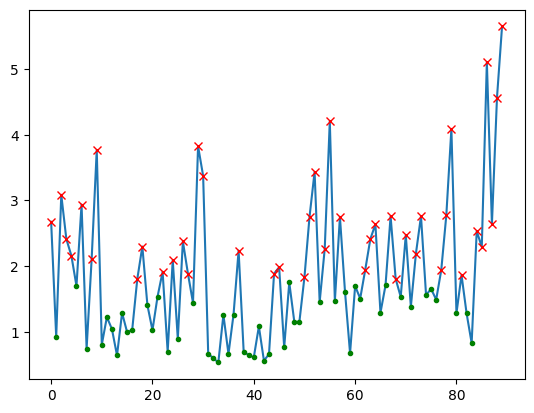

In [13]:
from scipy.spatial import distance
# test_points = np.array(df_test.iloc[:,0:12])
# train_points = np.array(df_train.iloc[:,0:12])
# all_points = np.array(df.iloc[:,0:12])
test_points = np.concatenate([df_test.iloc[:,0:12],df_test.iloc[:,19:20]],axis=1)
train_points = np.concatenate([df_train.iloc[:,0:12],df_train.iloc[:,19:20]],axis=1)
all_points = np.concatenate([df.iloc[:,0:12],df.iloc[:,19:20]],axis=1)
covariance_matrix = np.cov(all_points.T)
#inv_covariance_matrix = np.linalg.inv(covariance_matrix)
inv_covariance_matrix = np.linalg.pinv(covariance_matrix)

distances_of_test_from_train = np.array([distance.mahalanobis(x, y, inv_covariance_matrix)
                          for x in test_points for y in train_points])
print(test_points.shape,train_points.shape,distances_of_test_from_train.shape)
distances_of_test_from_train = distances_of_test_from_train.reshape(test_points.shape[0], len(train_points))
print(distances_of_test_from_train.shape)
min_distances_of_test_from_train_dataset = np.min(distances_of_test_from_train, axis=1)
print(min_distances_of_test_from_train_dataset.shape)

far_list = min_distances_of_test_from_train_dataset>1.8
near_list = min_distances_of_test_from_train_dataset<=1.8
print(far_list)
plt.plot(min_distances_of_test_from_train_dataset)
plt.plot(np.arange(len(far_list))[far_list],min_distances_of_test_from_train_dataset[far_list],"x",c="red")
plt.plot(np.arange(len(near_list))[near_list],min_distances_of_test_from_train_dataset[near_list],".",c="green")
plt.show()

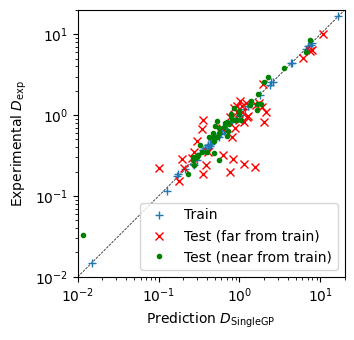

In [21]:
fig=plt.figure(figsize=(5,3.5))
ax=fig.add_subplot()
D_min = 0.01 #df["D_exp"].min()
D_max = 20 #df["D_exp"].max()
ax.plot([D_min,D_max],[D_min,D_max],"--",color="k",lw=0.5)
ax.plot(np.exp(mean_train_1),df_train["D_exp"],"+",label="Train")
# ax.plot(np.exp(mean_test_1),df_test["D_exp"],".",label="Test")
ax.plot(np.exp(mean_test_1)[far_list],np.array(df_test["D_exp"])[far_list],"x",c="red",label="Test (far from train)")
ax.plot(np.exp(mean_test_1)[near_list],np.array(df_test["D_exp"])[near_list],".",c="green",label="Test (near from train)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(D_min,D_max)
ax.set_ylim(D_min,D_max)
ax.set_aspect("equal")
ax.set_aspect("equal")
ax.set_xlabel(r"Prediction $D_\mathrm{SingleGP}$")
ax.set_ylabel(r"Experimental $D_\mathrm{exp}$")
ax.legend(loc="lower right")
fig.tight_layout()
fig.savefig("Mah.pdf",bbox_inches="tight")
plt.show()